## Introdução

O objetivo deste projeto é gerar estimadores para a resposta ao impulso de um sistema 'desconhecido':
 - No caso, descobrir qual a resposta ao impulso de uma garrafa;

[Projeto2.pdf](https://github.com/tallesviana/Stochastic_processes/blob/master/Proj%232/res/Estimador.pdf) :
_" [...] A estimação da resposta ao impulso pode ser feita colocando um ruído branco na entrada do sistema, observando sua saída, e fazendo algumas operações. Por exemplo, para medir a resposta ao impulso da garrafa, podemos colocar um alto falante tocando um ruído branco conhecido, w[k], medir com um microfone o áudio resultante dentro da garrafa, r[k], e usar esses dois sinais para a estimação. [...] "_

Importanto as bibliotecas necessárias:

In [1]:
%matplotlib inline
from scipy.io import wavfile
from scipy.linalg import solve_toeplitz
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd

---
### Qual o output simulado do sistema ?

Diretamente da proposta do projeto [Projeto2.pdf](https://github.com/tallesviana/Stochastic_processes/blob/master/Proj%232/res/Estimador.pdf), iremos simular o sinal passando pelo sistema:

_" [...] Antes de começar, usar um alto falante para medir a resposta ao impulso
é muito trabalhoso para os fins desse projeto. Vamos então usar a resposta
ao impulso da garrafa do vídeo acima e simular esse experimento. Para isso,
você vai ler o arquivo de áudio com a resposta ao impulso, **h[k]**, gerar o ruído
de excitação **w[k]** e o ruído de leitura **n[k]**, e vai simular a gravação usando
uma convolução: **r[k] = w[k] * h[k] + n[k]**. Assuma que o ruído de leitura
tem variância 0.01. [...] "_

Sendo assim, nosso sinal de saída é:

\begin{equation*}
r[k] = w[k] * h[k] + n[k]
\end{equation*}

In [2]:
## Simulador do Sinal de Saída     w[k] ---|h[k]|---->  r[k]

def sim_output_measurement(impulse_response, noise_samples=10000):

    #print("Tamanho da resposta ao impulso real: {}".format(impulse_response.shape))
    
    w = np.random.normal(loc=0, scale=1, size=noise_samples)
    #print("Tamanho do white noise de excitaçao: {}".format(w.shape))

    # convolve with the impulse response h[k]
    r_k = np.convolve(w, h, mode='full')
    
    #then, sum with the reading noise N - (0, 0.1) with the size of the convolution
    r_k = r_k[:noise_samples] + np.random.normal(loc=0, scale=0.1, size=noise_samples)
    #print("Tamanho do sinal gerado: {}".format(r_k.shape))
    
    return r_k, w

---
### Como verificar a qualidade do estimador?

Função que verifica a qualidade do estimador baseado na distância entre o estimador e a resposta ao impulso original:

\begin{equation*}
erro = \frac{\sum | h[k] - \hat{h}[k] |^2}{\sum | h[k] |^2}
\end{equation*}

In [3]:
def estimation_error(estimator, reference):
  error = np.sum((reference - estimator) ** 2)/np.sum(reference ** 2)
  return error

Função para plotar as formas de onda:

In [4]:
def plot_estimators(estimated, real):
  plt.plot(real, label='Real');
  plt.plot(estimated, alpha=0.6, label='Estimated');
  plt.title("Impulse response comparison: Estimator vs Real")
  plt.xlabel(r'$k$')
  plt.ylabel("Amplitude")
  if len(estimated) > 1:
    plt.legend();
  plt.show();
  print("Erro do estimador de: {0:.3f} %".format(estimation_error(estimated, real)*100))

---


## Carregando o aúdio da responsa ao impulso

Fazendo a normalização da série e truncando em 6000 samples

In [5]:
audio_garrafa = "res/Garrafa.wav"

Tamanho da resposta ao impulso: 6000


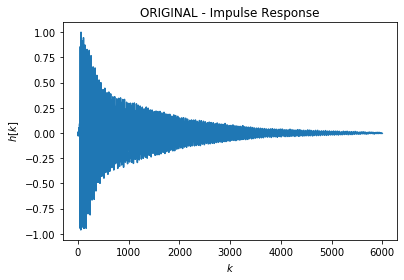

In [6]:
srate, h = wavfile.read(audio_garrafa)
h = h[:6000]/np.max(np.abs(h), axis=0)

print("Tamanho da resposta ao impulso: {}".format(h.size))
plt.plot(h)
plt.title("ORIGINAL - Impulse Response")
plt.ylabel(r'$h[k]$')
plt.xlabel(r'$k$')
plt.show()

#ipd.Audio(h, rate=srate)

---

# 2 - Estimação por Correlação

## 2.1 - Demonstração

A correlação cruzada de duas sequência pode ser estimada por:

\begin{equation*}
\rho [k] = \frac{1}{K} \sum_{m=0}^{K} r[m] w[m-k]
\end{equation*}

Tal correlação pode ser obtida passasando o mesmo sinal **_r[k]_** por um filtro com resposta **_w[-k]_** :


Sendo: \begin{align} w[m-k] & = w[-(k-m)]: \\
\rho [k] & = \frac{1}{K} \sum_{m=0}^{K} r[m] w[-(k-m)] \\
\end{align}

Sabendo que essa soma é a convolução:
\begin{align}
\sum_{m=0}^{K} r[m] w[-(k-m)] & = r[k] * w[-k] 
\end{align}

Isso nos leva à:

\begin{align}
\rho[k]\ = \frac{1}{K}r[k] * w[-k]
\end{align}

Que é justamente a passagem do sinal **r[k]** pelo filtro **w[-k]**.

## 2.2 - O estimador

No capítulo 19 do livro do Kay _Intuitive Probability and Random Processes Using MATLAB_, é discutido que a **Densidade Espectral da Potência Cruzada** entre saída e entrada é dada pela **Densidade Espectral da Potência** do sinal de entrada multiplicada pela resposta em frequência do sistema:

\begin{align}
P_{xy} & = H(f)P_x(f)
\end{align}

Portanto, no nosso caso, onde a entrada é dada pelo ruído branco temos:

\begin{align}
\mathcal{F}\{\rho[k]\} & = H(f) \mathcal{F}\{r_w[k]\} \\
H(f) & = \frac{\mathcal{F}\{\rho[k]\}}{\mathcal{F}\{r_w[k]\}} \\
\end{align}

\begin{align}
\text{Onde } \mathcal{F}\{r_w[k]\}& \text{ é a PSD do ruído branco, que pode ser considerada igual à sua variância 1:}\\
\end{align}

Portanto, temos nosso primeiro estimador:

\begin{align}
H(f) & = \frac{\mathcal{F}\{\rho[k]\}}{1} \\
\hat{h}[k] & = \rho[k] = \frac{1}{K}r[k] * w[-k]
\end{align}


## 2.3 - Implementação

Vamos agora implementar o estimador acima:

\begin{align}
\hat{h}[k] & = \rho[k] = \frac{1}{K}r[k] * w[-k]
\end{align}

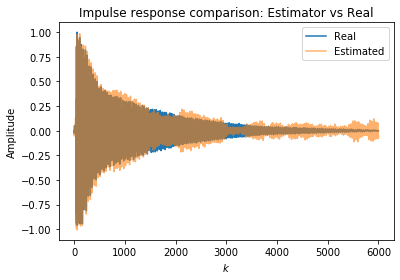

Erro do estimador de: 7.363 %


In [7]:
# Definindo o número de samples da nossa excitação
num_samples_excitation = 60000

# Simulando o sinal de saída, dado que o sinal de entrada é um ruído branco
r_k, w_noise = sim_output_measurement(h, num_samples_excitation)

#
#  Correlação cruzada entre a saída e a entrada
#

p_k = np.correlate(r_k, w_noise, 'full')
p_k = p_k/len(r_k)

#
#  Nosso primeiro estimador é dado abaixo
#

h_est =p_k[num_samples_excitation-1:num_samples_excitation+len(h)-1]

plot_estimators(h_est, h)

ipd.Audio(h_est, rate=srate)

---
# 3 - Melhorando a estimação

In [8]:
# PODEMOS FAZER UMA MÉDIA DAS VARIAS CORRELAÇÕES CRUZADAS
# DE DIFERENTES REALIZAÇÕES
def multiple_cross_correlations(h, num_samples_excitation, iterations):
  
  ccfs = 0

  for i in range(iterations):

      # Obtendo o output de uma realização
      output, w_noise = sim_output_measurement(h, num_samples_excitation)

      # Obtendo a correlação
      correlation = np.correlate(output, w_noise, mode='full')/len(output)

      ccfs = ccfs + correlation

  return ccfs/iterations

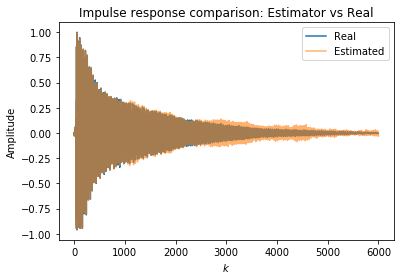

Erro do estimador de: 1.652 %


In [9]:
# Escolha os dois parâmetros abaixo!

num_samples=60000
iterations = 5

estimator = multiple_cross_correlations(h, num_samples, iterations)

estimator = estimator[num_samples-1:num_samples+len(h)-1]
plot_estimators(estimator, h)

ipd.Audio(estimator, rate=srate)

---

# 4 - Mínimo Erro Quadrático Médio (MMSE)

[Projeto2.pdf](https://github.com/tallesviana/Stochastic_processes/blob/master/Proj%232/res/Estimador.pdf) : _Finalmente, vamos estimar o canal usando um estimador de mínimo erro quadrático médio. Para isso, vamos considerar que os ruídos e o sinal medido pelo microfone são processos estocásticos $R[k]$, $W[k]$ e $N[k]$. Para começar,mostre que podemos escrever $R[k] = \mathbf{W}^T[k]\mathbf{h} + N[k]$, mostrando como os vetores $\mathbf{h}$ e $\mathbf{W}^T[k]$ podem ser escritos, respectivamente, a partir da resposta ao impulso do canal, h[k], e a partir das amostras do ruído de excitação, W[k]._

Sabemos que o sinal simulado da saída é dado por:

\begin{equation*}
r[k] = w[k] * h[k] + n[k]
\end{equation*}

Como a convolução é dada por:

\begin{equation*}
w[k] * h[k] =  \sum_{m=0}^{K} h[m]w[k-m]
\end{equation*}

Podemos definir a convolução como o produto interno dos vetores $\mathbf{h}$ e $\mathbf{W}^T[k]$:

\begin{align}
\mathbf{h} & = [ h_0, h_1, ... , h_K ]^T \\
\mathbf{W}^T[k] & = [ W[k], W[k-1], ... , W[k-K] ]
\end{align}

Assim, podemos escrever da seguinte forma:

\begin{align}
R[k] = \mathbf{W}^T[k] \mathbf{h} + N[k]
\end{align}

---
[...] _Finalmente, concluímos que a melhor estimativa da resposta ao impulso do canal, de acordo com esse critério, deve satisfazer_ [...]

\begin{equation*}
\mathbb{E}\{ \mathbf{W}[k] \mathbf{W}^T[k]\}\mathbf{\hat{h}} = \mathbb{E}\{ \mathbf{W}[k] R[k]\}
\end{equation*}

Que pode ser resolvido usando `solve_toeplitz` ($Ax=B$), onde $x=\mathbf{\hat{h}}$

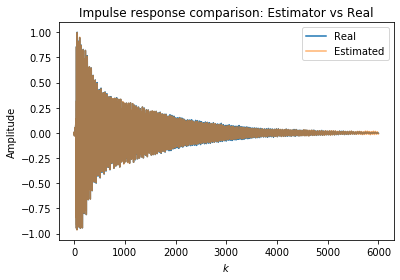

Erro do estimador de: 0.094 %


In [10]:
num_samples = 60000

# Simulando o sinal de saída e o ruído branco
r_k, w_n = sim_output_measurement(h, num_samples)

# E[W[k] * R[k]]
right_toeplitz = np.correlate(r_k, w_n, mode='full')/len(r_k)

# E[W[k] Wt[k]]
column_toeplitz = np.correlate(w_n, w_n, mode='full')/len(w_n)

#
# Escolhendo e truncando o sinal válido (essa é a parte difícil)
# 
right_toeplitz = right_toeplitz[num_samples-1:num_samples+len(h)]
column_toeplitz = column_toeplitz[num_samples-1:num_samples+len(h)]

# Resolvendo o sistem de Toeplitz Ax = B
h_est_toeplitz = solve_toeplitz(column_toeplitz, right_toeplitz)

plot_estimators(h_est_toeplitz[:len(h)], h)
ipd.Audio(h_est_toeplitz, rate=srate)

De acordo com o que foi demonstrado nos experimentos acima, a estimação via MMSE foi muito precisa em relação à apenas estimar utilizando a correlação cruzada entre o sinal de saída e o ruído branco de excitação

---
---

### References used to make this project

https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Typesetting%20Equations.html

https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed